In [17]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, page_map, quest_map, attention, did_map
from scipy.stats import shapiro, yeojohnson, kruskal
import scikit_posthocs as sp
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json

In [18]:
def get_pvalue(x):
    return round(shapiro(x).pvalue, 5)

In [19]:
page_id = '7'
password_response, time_response, survey_response, dids = get_responses()
questions = get_questions()

Total: 163; 
Attentive: 131; Non Attentive: 32


In [20]:
survey_response_df = pd.DataFrame(survey_response)

quest = pd.json_normalize(survey_response_df[page_id]).astype(float)
quest.drop(attention.get(page_id).keys(), axis=1, inplace=True)
# normalize low and high likert scale values
normqsid = ['1-2', '1-4', '1-7', '1-10', '1-12', '1-13', '1-16']
normquest = 8 - quest[normqsid]
quest.update(normquest)

# normalize scale 1 to 8 to scale -3 to 3
normquest = quest - 4
quest.update(normquest)

new_columns = {}
for qsid in quest.columns:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_columns[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"')).get('elements').get(likert_scale)
quest.rename(columns=new_columns, inplace=True)

# display(quest.head())
# display(quest.describe())

## Ranking of Each Categories 

In [21]:
cats = {}
for k, v in quest_map.items():
    temp = quest[v]
    cats[k] = temp.mean(axis=1).to_dict()
quest = pd.DataFrame(cats)
quest['did'] = dids
quest['design'] = quest['did'].apply(lambda x: get_design(x))
quest.drop('did', axis=1, inplace=True)
quest.to_csv('data/csvs/quest.csv', index=False)
display(quest)
display(quest.describe())

,Perspicuity,Aesthetics,Usefulness,Clarity,design
0,-1.50,-2.75,0.25,-3.00,Metaphor
1,2.25,-2.75,0.25,2.00,Personal
2,3.00,0.50,2.00,2.75,Consequences
3,1.50,2.25,2.50,2.50,Consequences
4,3.00,2.50,3.00,3.00,Logos
...,...,...,...,...,...
126,3.00,1.00,1.75,2.25,Logos
127,2.00,0.50,2.25,1.00,Consequences
128,0.75,1.25,0.00,1.00,Professional
129,2.25,1.25,1.50,1.75,Logos


,Perspicuity,Aesthetics,Usefulness,Clarity
count,131.000000,131.000000,131.000000,131.000000
mean,1.662214,1.009542,1.307252,1.639313
std,1.089691,1.199521,1.359640,1.121538
min,-1.500000,-2.750000,-3.000000,-3.000000
25%,0.875000,0.375000,0.500000,1.000000
50%,1.750000,1.000000,1.500000,1.750000
75%,2.625000,2.000000,2.375000,2.500000
max,3.000000,3.000000,3.000000,3.000000


### Average of categories based on designs

In [22]:
did_quest = quest.groupby('design').mean()
did_quest

,Perspicuity,Aesthetics,Usefulness,Clarity
design,,,,
Consequences,1.500000,0.653846,0.875000,1.394231
Logos,2.175926,1.564815,1.805556,2.064815
Metaphor,1.221154,1.105769,1.201923,1.346154
Personal,1.673077,0.788462,1.500000,1.836538
Professional,1.721154,0.913462,1.134615,1.538462


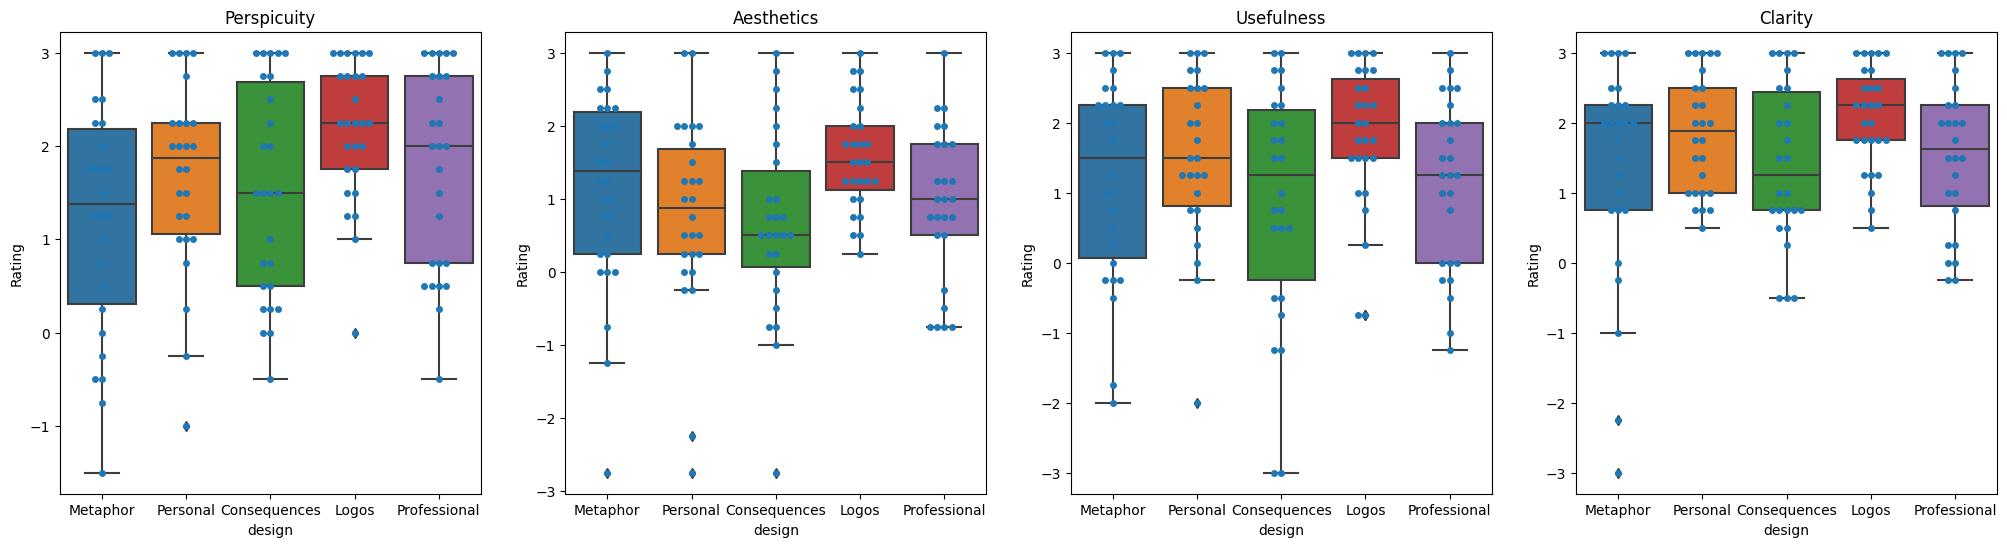

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
for i, param in enumerate(quest_map):
    sns.boxplot(data=quest, x='design', y=param, ax=axes[i])
    sns.swarmplot(data=quest, x='design', y=param, ax=axes[i])
    axes[i].set_ylabel('Rating')
    axes[i].set_title(param)

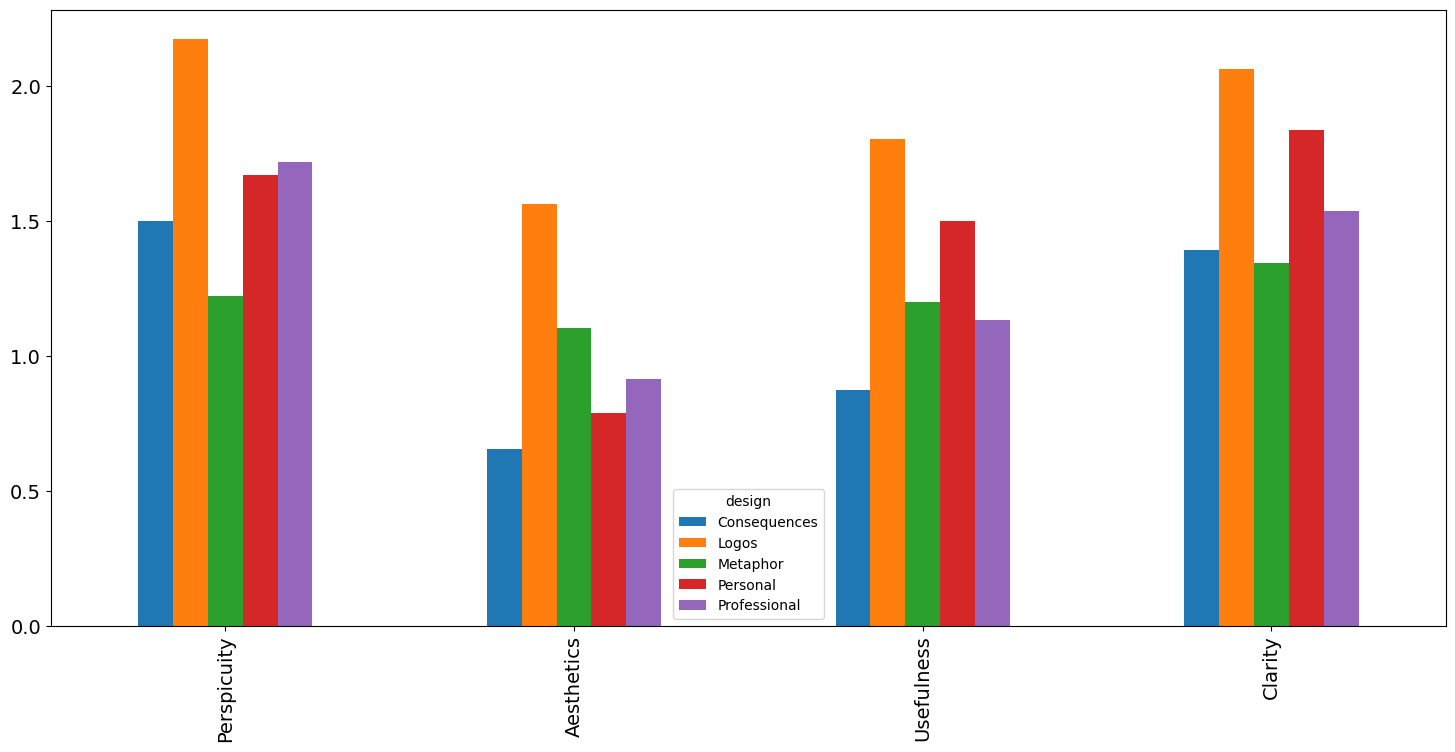

In [24]:
chart = did_quest.T.plot.bar(figsize=(18, 8), fontsize=14, style=".-")

## Significance Text

In [25]:
data = quest

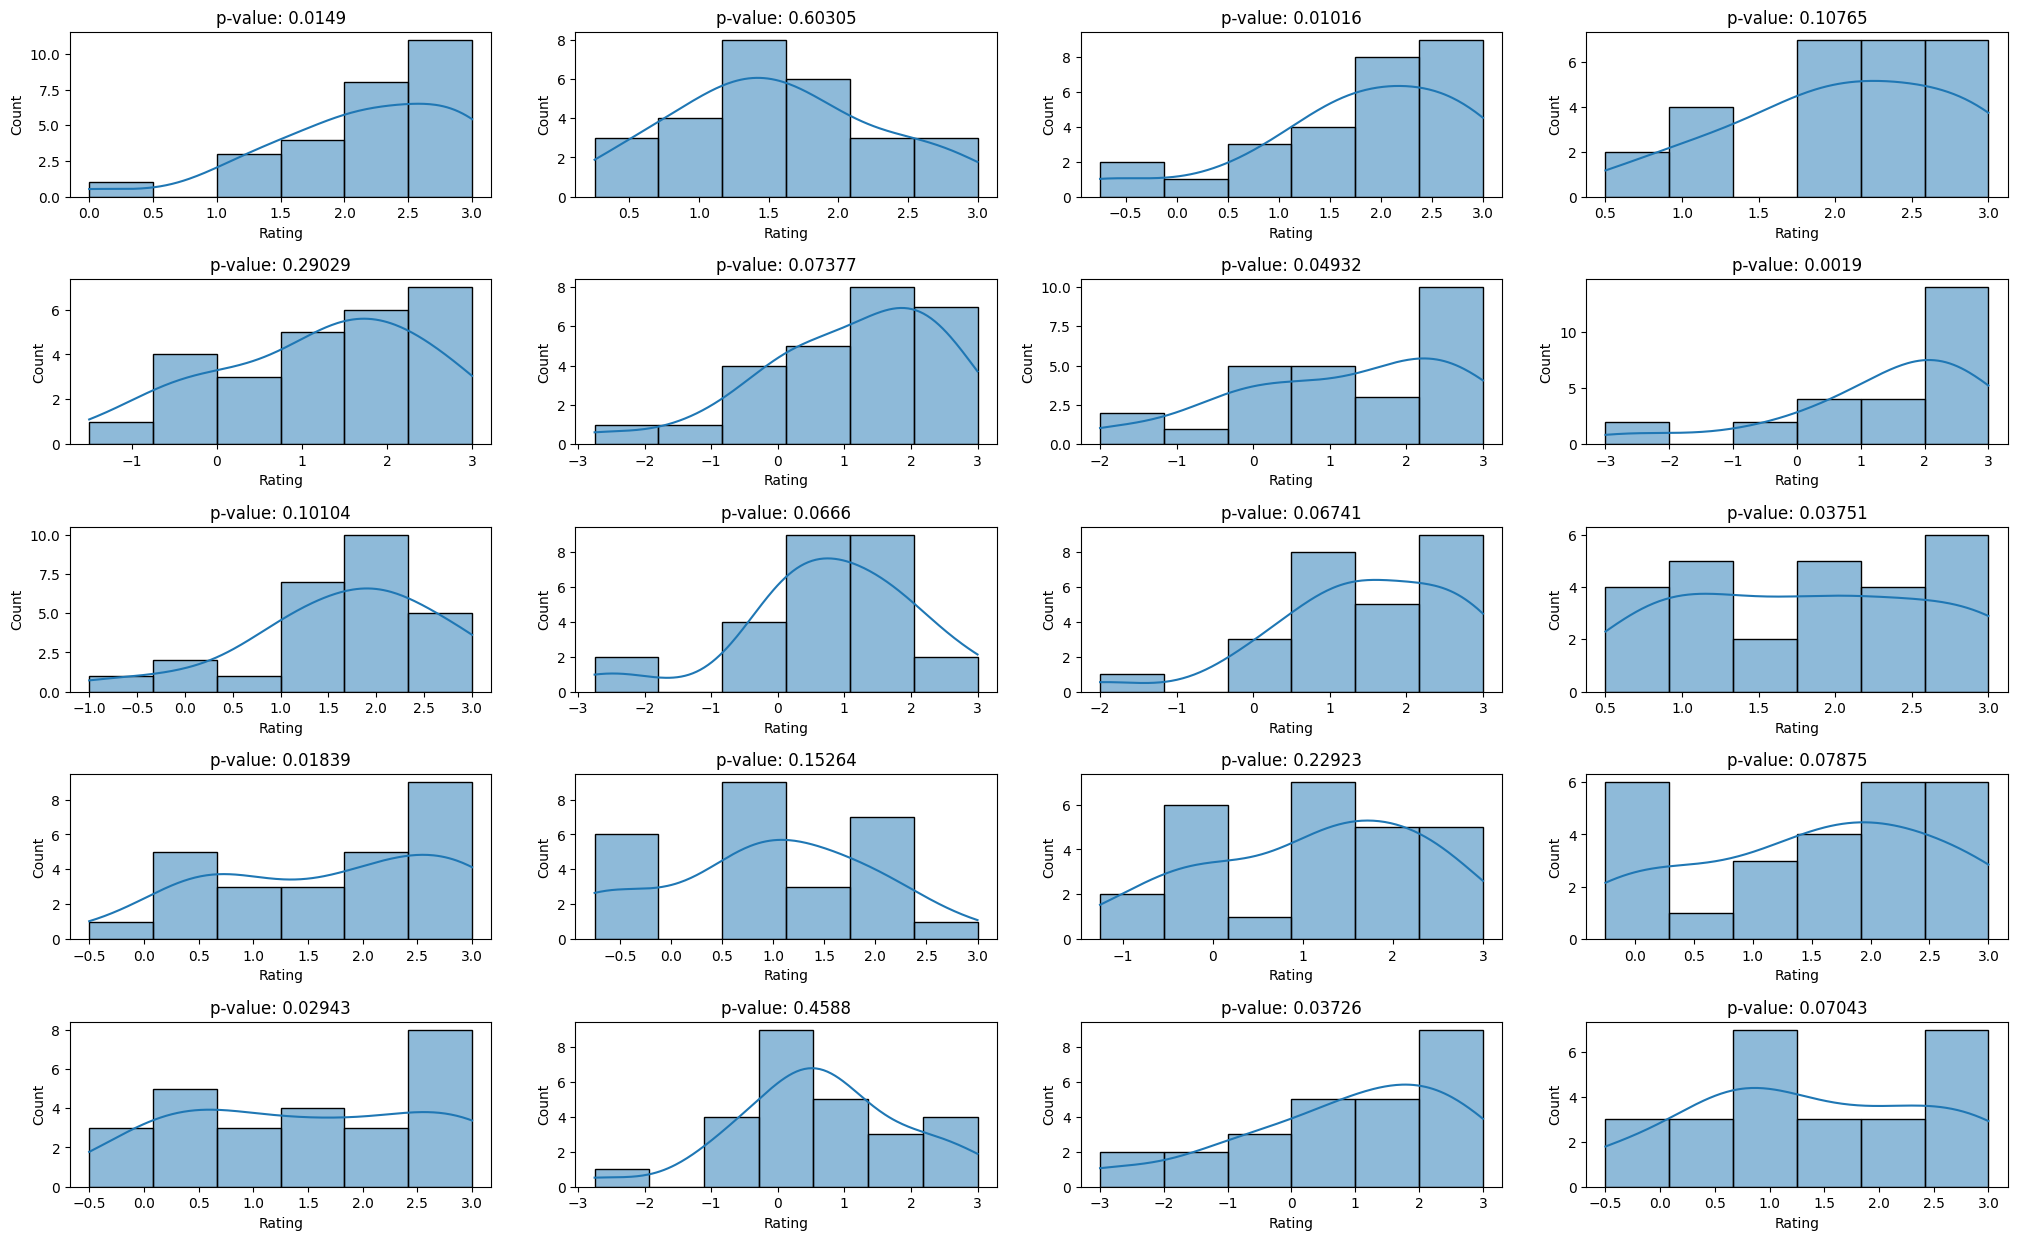

In [26]:
fig, axes = plt.subplots(5, 4, figsize=(25, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i, design in enumerate(did_map.values()):
    for j, param in enumerate(quest_map):
        fdata = data[data['design']==design]
        sns.histplot(data=fdata, x=param, kde=True, ax=axes[i][j])
        axes[i][j].set_xlabel('Rating')
        axes[i][j].set_title(f'p-value: {get_pvalue(fdata[param])}')

In [27]:
test = {}
designs = []
for i, param in enumerate(quest_map):
    test[param] = []
    for design in did_map.values():
        test[param].append(data[data['design']==design][param].to_list())
        designs.append(design) if i<=0 else None

# Performing kruskal test
for k, v in test.items():
    print(f'{k}: {kruskal(*v)}')

Perspicuity: KruskalResult(statistic=9.465201045652991, pvalue=0.050467220542204934)
Aesthetics: KruskalResult(statistic=10.500146417569002, pvalue=0.032794973191317314)
Usefulness: KruskalResult(statistic=6.2143703334270795, pvalue=0.18370074208395318)
Clarity: KruskalResult(statistic=6.123319186525033, pvalue=0.1901260631904977)


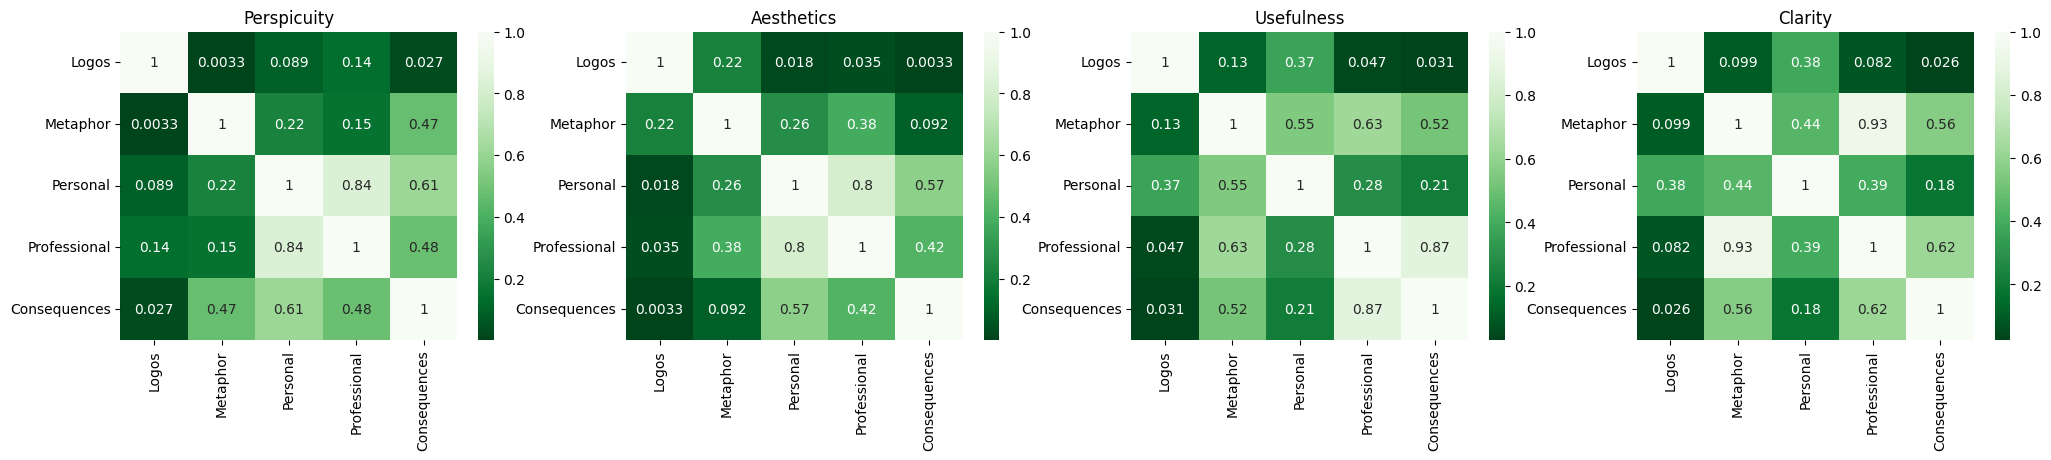

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(25, 4))
for i, param in enumerate(quest_map):
    data = sp.posthoc_dunn(test[param])
    data.index = data.index.map(get_design)
    data.columns = data.columns.map(get_design)
    sns.heatmap(data, annot=True, ax=axes[i], cmap="Greens_r")
    axes[i].set_title(param)

In [29]:
quest

,Perspicuity,Aesthetics,Usefulness,Clarity,design
0,-1.50,-2.75,0.25,-3.00,Metaphor
1,2.25,-2.75,0.25,2.00,Personal
2,3.00,0.50,2.00,2.75,Consequences
3,1.50,2.25,2.50,2.50,Consequences
4,3.00,2.50,3.00,3.00,Logos
...,...,...,...,...,...
126,3.00,1.00,1.75,2.25,Logos
127,2.00,0.50,2.25,1.00,Consequences
128,0.75,1.25,0.00,1.00,Professional
129,2.25,1.25,1.50,1.75,Logos


### Correlation between parameters

In [30]:
cormat = quest.corr(method='pearson')

/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_45771/3786462891.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = quest.corr(method='pearson')


<AxesSubplot: >

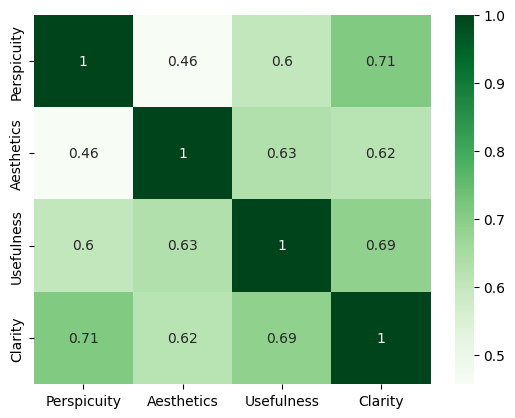

In [31]:
sns.heatmap(cormat, annot=True, cmap="Greens")


/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_45771/2144205309.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = quest[quest['design']==design].corr(method='pearson')


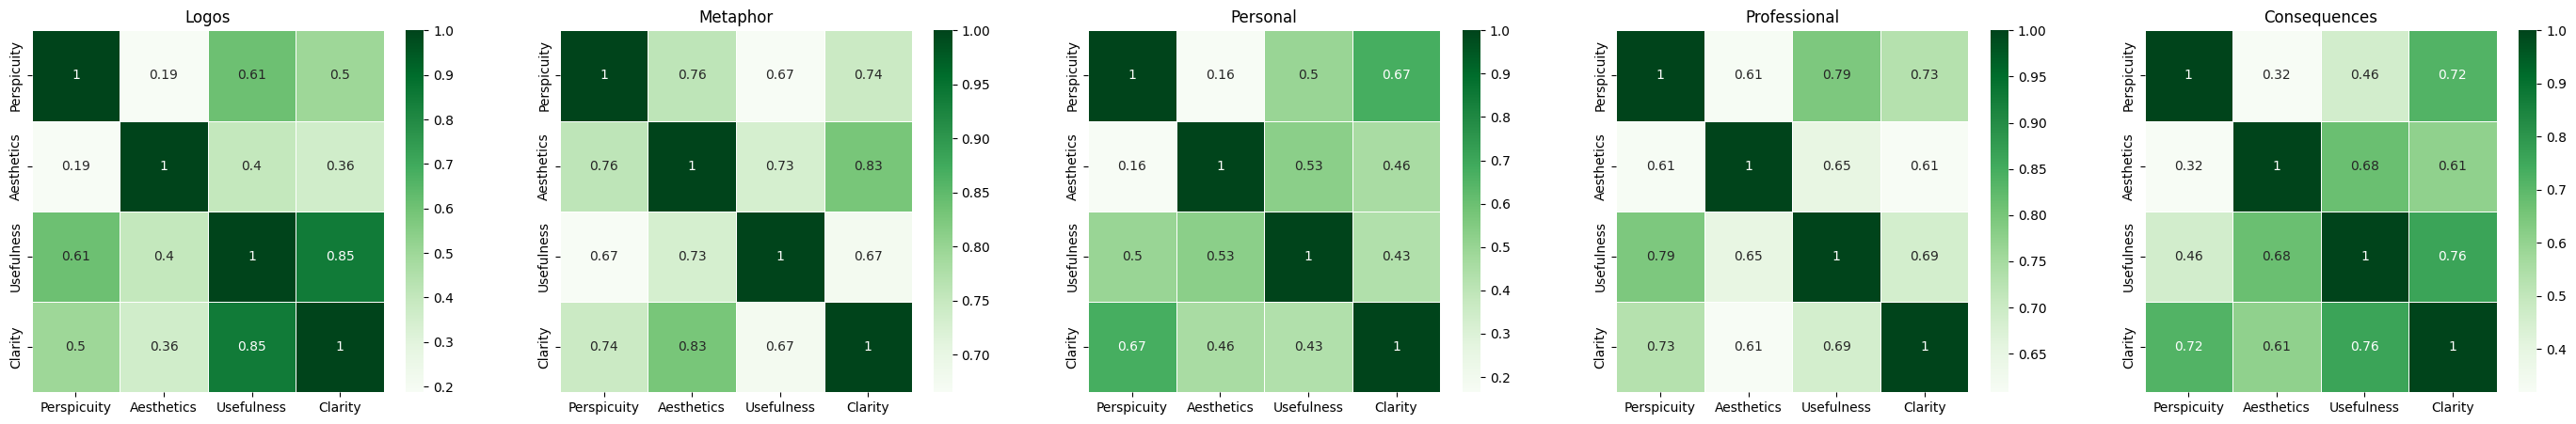

In [32]:
fig, axes = plt.subplots(1, 5,  figsize=(35, 5))

for i, design in enumerate(did_map.values()):
    cormat = quest[quest['design']==design].corr(method='pearson')
    sns.heatmap(cormat, annot=True, cmap="Greens", linewidths=.5, ax=axes[i])
    axes[i].set_title(design)